In [23]:
import numpy as np
import pandas as pd
from scipy.stats import norm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
import matplotlib.pyplot as plt

## Data generation

In [2]:
np.random.seed(42)

n_samples = 100000

S = np.random.uniform(50, 150, n_samples) # Spot Price: Between $50 and $150
K = np.random.uniform(50, 150, n_samples) # Strike Price: Between $50 and $150
T = np.random.uniform(0.25, 2, n_samples) # Time to Maturity: Between 3 months and 2 years
r = np.random.uniform(0.01, 0.05, n_samples) # Risk-free Rate: Between 1% and 5%

# Introducing volatility skew: Options with lower strike prices will tend to have higher volatilities
sigma = np.random.uniform(0.1, 0.4, n_samples) + (K < S) * np.random.uniform(0.05, 0.15, n_samples)

# Creating a DataFrame to store these values
options_df = pd.DataFrame({
'Spot_Price': S,
'Strike_Price': K,
'Time_to_Maturity': T,
'Risk_free_Rate': r,
'Volatility': sigma
})
options_df.head()

,Spot_Price,Strike_Price,Time_to_Maturity,Risk_free_Rate,Volatility
0,87.454012,108.077904,0.744529,0.016282,0.366686
1,145.071431,102.697165,1.052684,0.013820,0.295664
2,123.199394,85.103695,0.423627,0.015518,0.229967
3,109.865848,99.321266,1.031965,0.028940,0.525141
4,65.601864,86.509664,0.605392,0.045381,0.230878


## Options pricing

In [5]:
def black_scholes_put_price(S, K, T, r, sigma, q=0):
  """
  Compute the Black-Scholes put option price.
  Parameters:
  - S: Spot price of the underlying asset
  - K: Strike price of the option
  - T: Time to maturity (in years)
  - r: Risk-free interest rate (annualized)
  - sigma: Volatility of the underlying asset (annualized)
  - q: Dividend yield (annualized). Default is 0 (no dividends).
  Returns:
  - Put option price
  """
  d1 = (np.log(S / K) + (r - q + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
  d2 = d1 - sigma * np.sqrt(T)
  put_price = K * np.exp(-r * T) * norm.cdf(-d2) - S * np.exp(-q * T) * norm.cdf(-d1)
  return put_price

# Compute put option prices using Black-Scholes formula
options_df['BS_Put_Price'] = black_scholes_put_price(
options_df['Spot_Price'],
options_df['Strike_Price'],
options_df['Time_to_Maturity'],
options_df['Risk_free_Rate'],
options_df['Volatility']
)
options_df[['Spot_Price', 'Strike_Price', 'Volatility', 'BS_Put_Price']].head()

,Spot_Price,Strike_Price,Volatility,BS_Put_Price
0,87.454012,108.077904,0.366686,24.191026
1,145.071431,102.697165,0.295664,2.102809
2,123.199394,85.103695,0.229967,0.029113
3,109.865848,99.321266,0.525141,15.590019
4,65.601864,86.509664,0.230878,19.065520


## Volatility Scew adjustment

In [7]:
# Adjusting the volatility skew based on how far OTM the option is and the magnitude of the strike price
delta_from_ATM = (options_df['Spot_Price'] - options_df['Strike_Price']).abs()
skew_factor = np.where(options_df['Strike_Price'] < options_df['Spot_Price'],delta_from_ATM / options_df['Strike_Price'], 0)

# Adjusting the volatility to introduce a more pronounced skew for OTM options and options with smaller strike prices
options_df['Adjusted_Volatility'] = options_df['Volatility'] + skew_factor * np.random.uniform(0.05, 0.2, n_samples)

# Compute put option prices using Black-Scholes formula with adjusted volatility
options_df['Adjusted_BS_Put_Price'] = black_scholes_put_price(
options_df['Spot_Price'],
options_df['Strike_Price'],
options_df['Time_to_Maturity'],
options_df['Risk_free_Rate'],
options_df['Adjusted_Volatility']
)
options_df[['Spot_Price', 'Strike_Price', 'Volatility', 'BS_Put_Price','Adjusted_BS_Put_Price']].head()

,Spot_Price,Strike_Price,Volatility,BS_Put_Price,Adjusted_BS_Put_Price
0,87.454012,108.077904,0.366686,24.191026,24.191026
1,145.071431,102.697165,0.295664,2.102809,2.967925
2,123.199394,85.103695,0.229967,0.029113,0.273305
3,109.865848,99.321266,0.525141,15.590019,16.073277
4,65.601864,86.509664,0.230878,19.065520,19.065520


## Data splitting

In [14]:
# Features and target variable
X = options_df[['Spot_Price', 'Strike_Price', 'Time_to_Maturity','Risk_free_Rate', 'Volatility']]
y = options_df['Adjusted_BS_Put_Price']

# Splitting the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20,random_state=42)
X_train.shape, X_test.shape

((80000, 5), (20000, 5))

## Machine Learning models

### Linear regression

In [18]:
# Initialize the Linear Regression model
lr_model = LinearRegression()
# Train the model
lr_model.fit(X_train, y_train)
# Predict on the test set
lr_predictions = lr_model.predict(X_test)
# Compute accuracy metrics
lr_mse = mean_squared_error(y_test, lr_predictions)
lr_mae = mean_absolute_error(y_test, lr_predictions)
lr_r2 = r2_score(y_test, lr_predictions)
lr_mse, lr_mae, lr_r2

(82.3065623567986, 7.410646174896288, 0.8020023793175671)

### Decision tree regressor

Decision Trees can capture non-linear relationships
in the data and might offer better performance than the linear model.

In [19]:
# Initialize the Decision Tree Regressor model
dt_model = DecisionTreeRegressor(random_state=42)
# Train the model
dt_model.fit(X_train, y_train)
# Predict on the test set
dt_predictions = dt_model.predict(X_test)
# Compute accuracy metrics
dt_mse = mean_squared_error(y_test, dt_predictions)
dt_mae = mean_absolute_error(y_test, dt_predictions)
dt_r2 = r2_score(y_test, dt_predictions)
dt_mse, dt_mae, dt_r2

(2.223669513605925, 1.0997790230558162, 0.9946507148364498)

### Random forest regressor

Random Forests, being an ensemble of decision trees, can often capture more intricate patterns in the data, providing potentially better predictive power than individual trees.

In [20]:
# Initialize the Random Forest Regressor model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
# Train the model
rf_model.fit(X_train, y_train)
# Predict on the test set
rf_predictions = rf_model.predict(X_test)
# Compute accuracy metrics
rf_mse = mean_squared_error(y_test, rf_predictions)
rf_mae = mean_absolute_error(y_test, rf_predictions)
rf_r2 = r2_score(y_test, rf_predictions)
rf_mse, rf_mae, rf_r2

(0.6235880143602184, 0.5833461234061046, 0.9984998894426648)

### Gradient boosted trees regressor

Gradient Boosting is a powerful ensemble technique that can provide high accuracy by iteratively correcting errors from previous trees

In [21]:
# Initialize the Gradient Boosting Regressor model
gb_model = GradientBoostingRegressor(random_state=42)
# Train the model
gb_model.fit(X_train, y_train)
# Predict on the test set
gb_predictions = gb_model.predict(X_test)
# Compute accuracy metrics
gb_mse = mean_squared_error(y_test, gb_predictions)
gb_mae = mean_absolute_error(y_test, gb_predictions)
gb_r2 = r2_score(y_test, gb_predictions)
gb_mse, gb_mae, gb_r2

(3.0127475411652225, 1.3659705360230645, 0.9927524995846423)

## Deep Learning models

### MLP regressor

Neural Networks can capture complex non-linear relationships in data and are particularly suited for large datasets.

In [22]:
# Neural networks benefit from feature scaling. So, we'll scale our features.
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
# Initialize the Neural Network (MLP) model
nn_model = MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=1000,random_state=42)
# Train the model
nn_model.fit(X_train_scaled, y_train)
# Predict on the test set
nn_predictions = nn_model.predict(X_test_scaled)
# Compute accuracy metrics
nn_mse = mean_squared_error(y_test, nn_predictions)
nn_mae = mean_absolute_error(y_test, nn_predictions)
nn_r2 = r2_score(y_test, nn_predictions)
nn_mse, nn_mae, nn_r2

(0.11641604855765761, 0.20049611905920114, 0.9997199482038414)

## Performance

MLP is the more accurate.

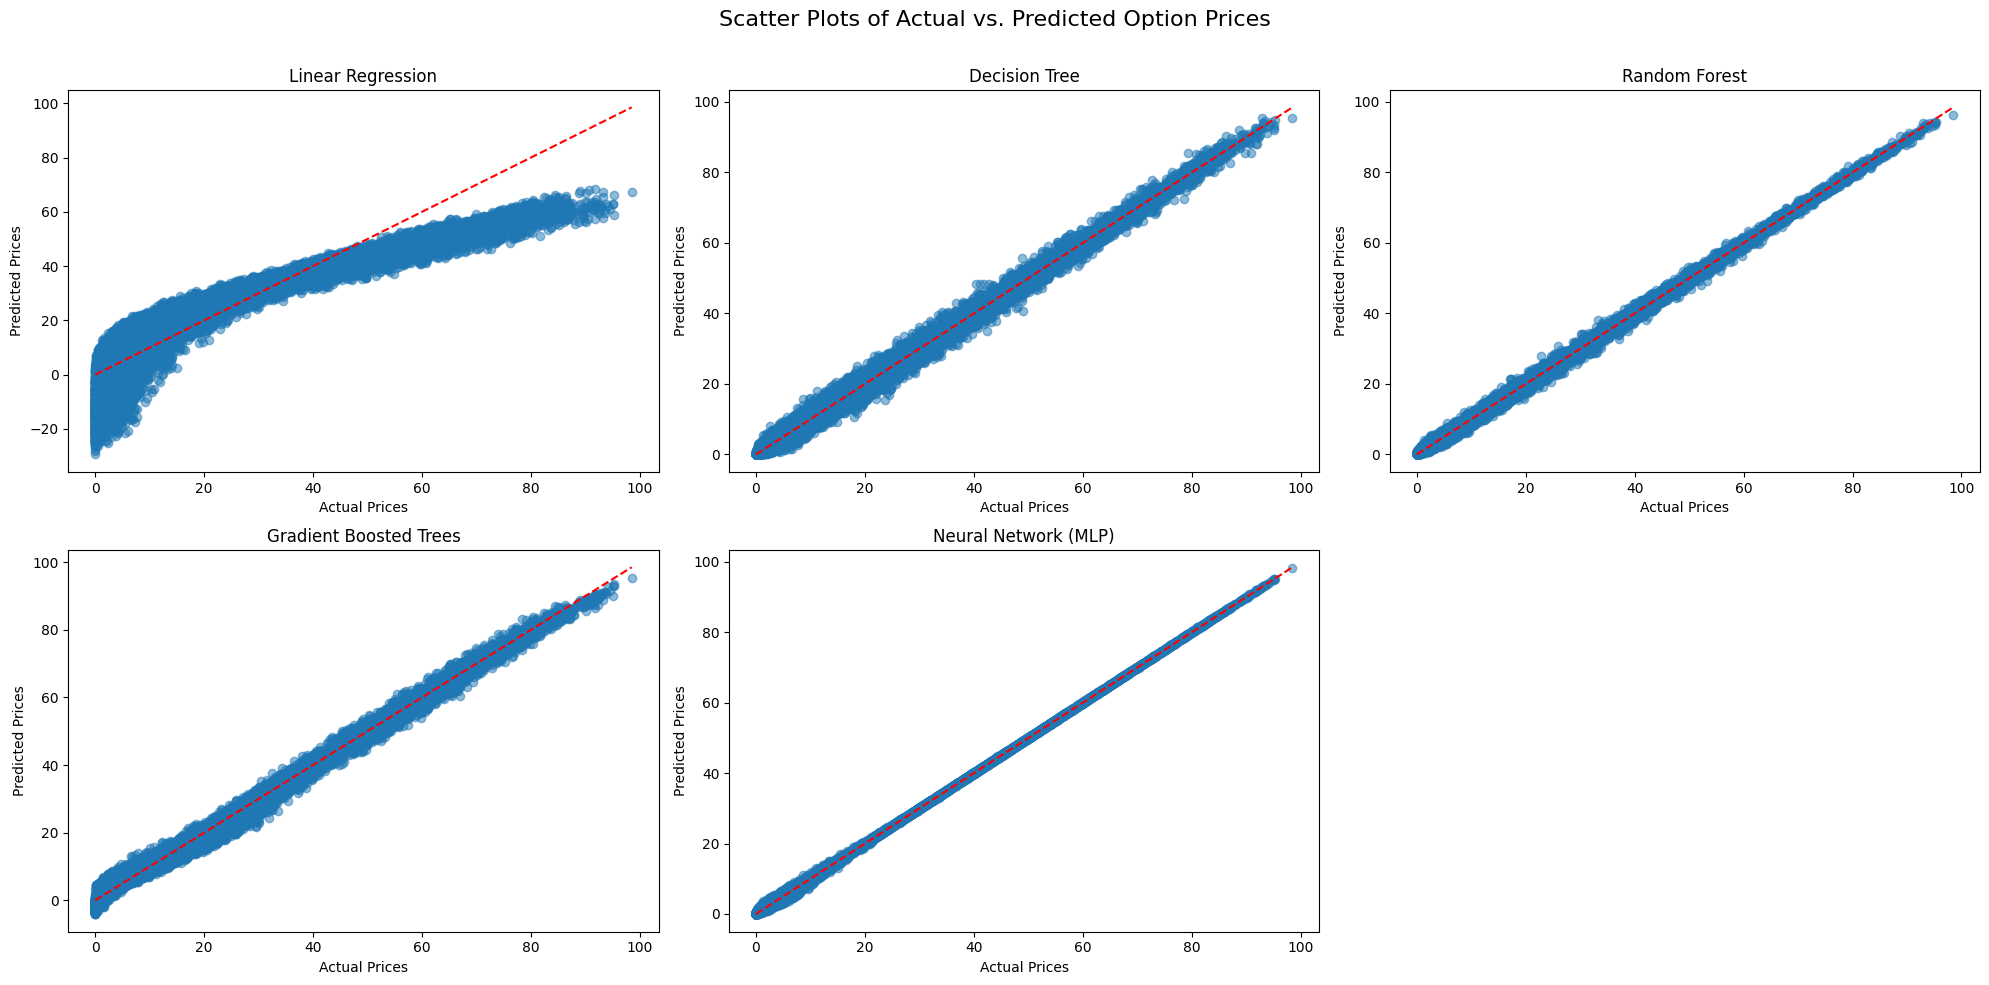

In [25]:
# Set up the figure and axes
fig, axs = plt.subplots(2, 3, figsize=(20, 10))
fig.suptitle('Scatter Plots of Actual vs. Predicted Option Prices', fontsize=16)
# Linear Regression Scatter Plot
axs[0, 0].scatter(y_test, lr_predictions, alpha=0.5)
axs[0, 0].plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--',color='red')
axs[0, 0].set_title('Linear Regression')
axs[0, 0].set_xlabel('Actual Prices')
axs[0, 0].set_ylabel('Predicted Prices')
# Decision Tree Scatter Plot
axs[0, 1].scatter(y_test, dt_predictions, alpha=0.5)
axs[0, 1].plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--',color='red')
axs[0, 1].set_title('Decision Tree')
axs[0, 1].set_xlabel('Actual Prices')
axs[0, 1].set_ylabel('Predicted Prices')
# Random Forest Scatter Plot
axs[0, 2].scatter(y_test, rf_predictions, alpha=0.5)
axs[0, 2].plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--',color='red')
axs[0, 2].set_title('Random Forest')
axs[0, 2].set_xlabel('Actual Prices')
axs[0, 2].set_ylabel('Predicted Prices')
# Gradient Boosted Trees Scatter Plot
axs[1, 0].scatter(y_test, gb_predictions, alpha=0.5)
axs[1, 0].plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--',color='red')
axs[1, 0].set_title('Gradient Boosted Trees')
axs[1, 0].set_xlabel('Actual Prices')
axs[1, 0].set_ylabel('Predicted Prices')
# Neural Network Scatter Plot
axs[1, 1].scatter(y_test, nn_predictions, alpha=0.5)
axs[1, 1].plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--',color='red')
axs[1, 1].set_title('Neural Network (MLP)')
axs[1, 1].set_xlabel('Actual Prices')
axs[1, 1].set_ylabel('Predicted Prices')
# Hide the empty subplot
axs[1, 2].axis('off')
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()